(<Figure size 7200x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3979d34630>)

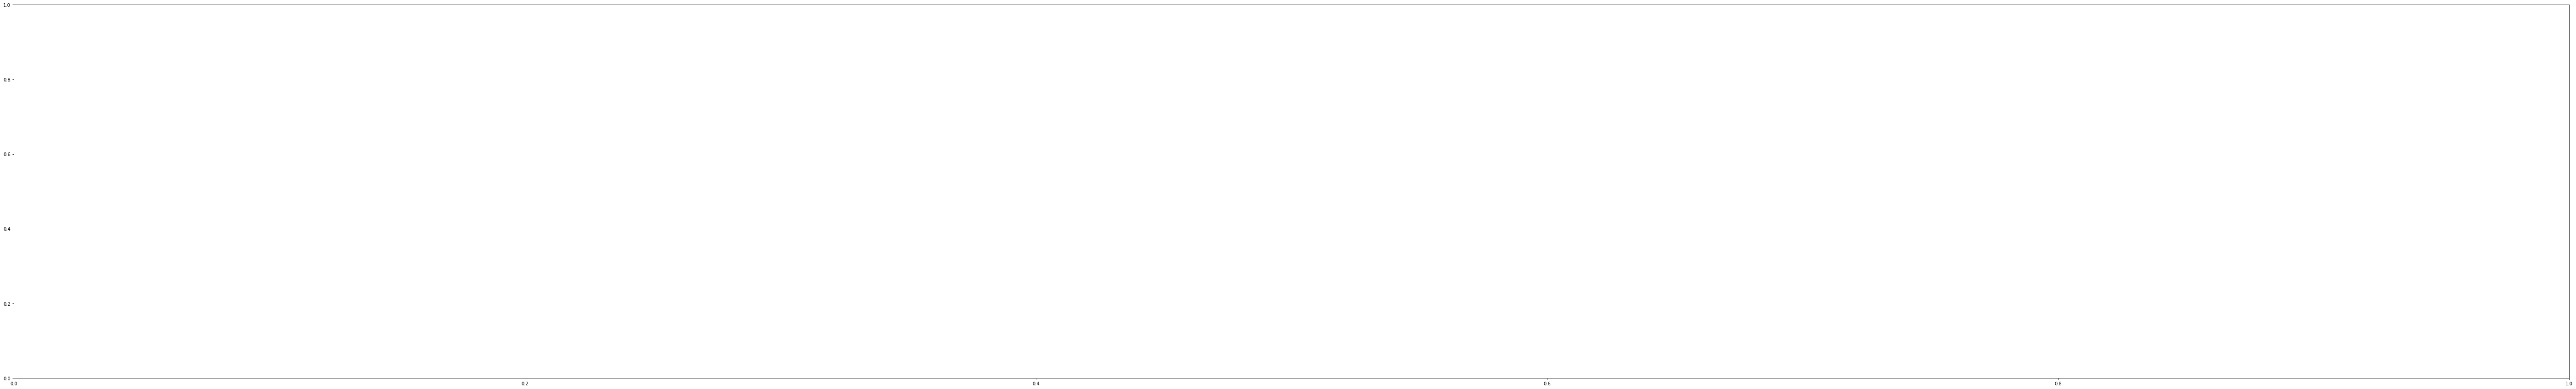

In [43]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
plt.subplots(figsize=(100,15))

In [44]:
df=pd.read_csv("train.csv")
df.shape
#df.drop(["Id","MiscFeature","GarageYrBlt","Fence","PoolQC","Alley"],axis=1,inplace=True)

(1460, 81)

In [45]:
for column in df:
    if df[column].isnull().any():
        print(column,df[column].isnull().sum())

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


# Creating 2 lists 

In [46]:

#creating a list of categorical columns and int columns
category_columns=df.select_dtypes(include=['object']).columns.tolist()
integer_columns=df.select_dtypes(include=['int64','float64']).columns.tolist()


# Replacing the missing values with conditions


In [5]:

for column in df:
    if df[column].isnull().any():
        if(column in category_columns):
            df[column]=df[column].fillna(df[column].mode()[0])
        else:
            df[column]=df[column].fillna(df[column].mean())

In [6]:
df.dropna(inplace=True)

# Check for duplicated Observations(Rows)



In [7]:
Duplicate_df=df.T
Duplicate_df.duplicated().sum() #if this comes more than 0 drop those columns(which are rows because we have transposed)
#unique_df = data_t.drop_duplicates(keep='first').T # drop and transpose
#unique_df.shape

0

# Check for duplicate features (Columns)


In [8]:
duplicated_feat = []
for i in range(0, len(df.columns)):
    #if i % 10 == 0:  # this helps me understand how the loop is going
      #  print(i)
 
    col_1 = df.columns[i]
 
    for col_2 in df.columns[i + 1:]:     # Loop from that columns to all the columns
        if df[col_1].equals(df[col_2]):    # if a duplicate is detected
            duplicated_feat.append(col_2)   #if yes then append in the list 
len(duplicated_feat)                    

#dropping the columns which are in the list i.e duplicate columns

df.drop(labels=duplicated_feat, axis=1, inplace=True)

# Check for constant feature using threshold in int or float columns

In [9]:
from sklearn.feature_selection import VarianceThreshold

In [10]:
feature_selector = VarianceThreshold(threshold=0.01) #set the threshold
integer_df=df.select_dtypes(exclude=['object'])
#integer_df.columns.drop(['SalePrice']) removing the target column
feature_selector.fit(integer_df)
feature_selector.get_support() 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [11]:
feature_selector.get_support()  #return true is not constant else False
[x for x in integer_df.columns if x not in integer_df.columns[feature_selector.get_support()]]

[]

# Heatmap


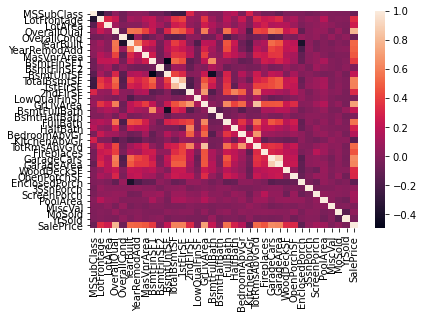

In [12]:

sns.heatmap(df.corr(),xticklabels=df.corr().columns.values,yticklabels=df.corr().columns.values)

Reading cleaned test file 

# Reading the cleaned Test file

In [65]:
df_test=pd.read_csv("cleanedtest2.csv")
df_test.shape

(1459, 74)

In [66]:
df_test.isna().any().sum()

0

# Concat training and testing csv 

In [67]:
final_df=pd.concat([df,df_test],axis=0)

In [68]:
final_df.shape

(2919, 81)

In [69]:
[x for x in final_df.columns if final_df[x].isna().any()]

['Id',
 'LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SalePrice']


# One hot encoding all the categorical columns



In [70]:
for column in category_columns:
    dummies=pd.get_dummies(final_df[column],drop_first=True)
    final_df.drop([column],axis=1,inplace=True)
    final_df=pd.concat([final_df,dummies],axis=1)
    #dummies=pd.get_dummies(final_df[column])

# Removing the duplicated column


In [71]:
final_df =final_df.loc[:,~final_df.columns.duplicated()]

# Test and Train Split 

In [72]:
df_Train=final_df.iloc[:1460,:]
df_Test=final_df.iloc[1460:,:]

In [55]:
df_Train.drop(["GarageYrBlt"],axis=1,inplace=True)

/home/bhavesh/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [73]:
Y_train=df_Train["SalePrice"]
X_train=df_Train.drop(["SalePrice"],axis=1)
X_train.shape

(1460, 182)

In [24]:
[x for x in df_Train.columns if df_Train[x].isna().any()]

[]

In [25]:
from sklearn.feature_selection import mutual_info_classif,mutual_info_regression

mi = mutual_info_regression(X_train, Y_train)
mi = pd.Series(mi)

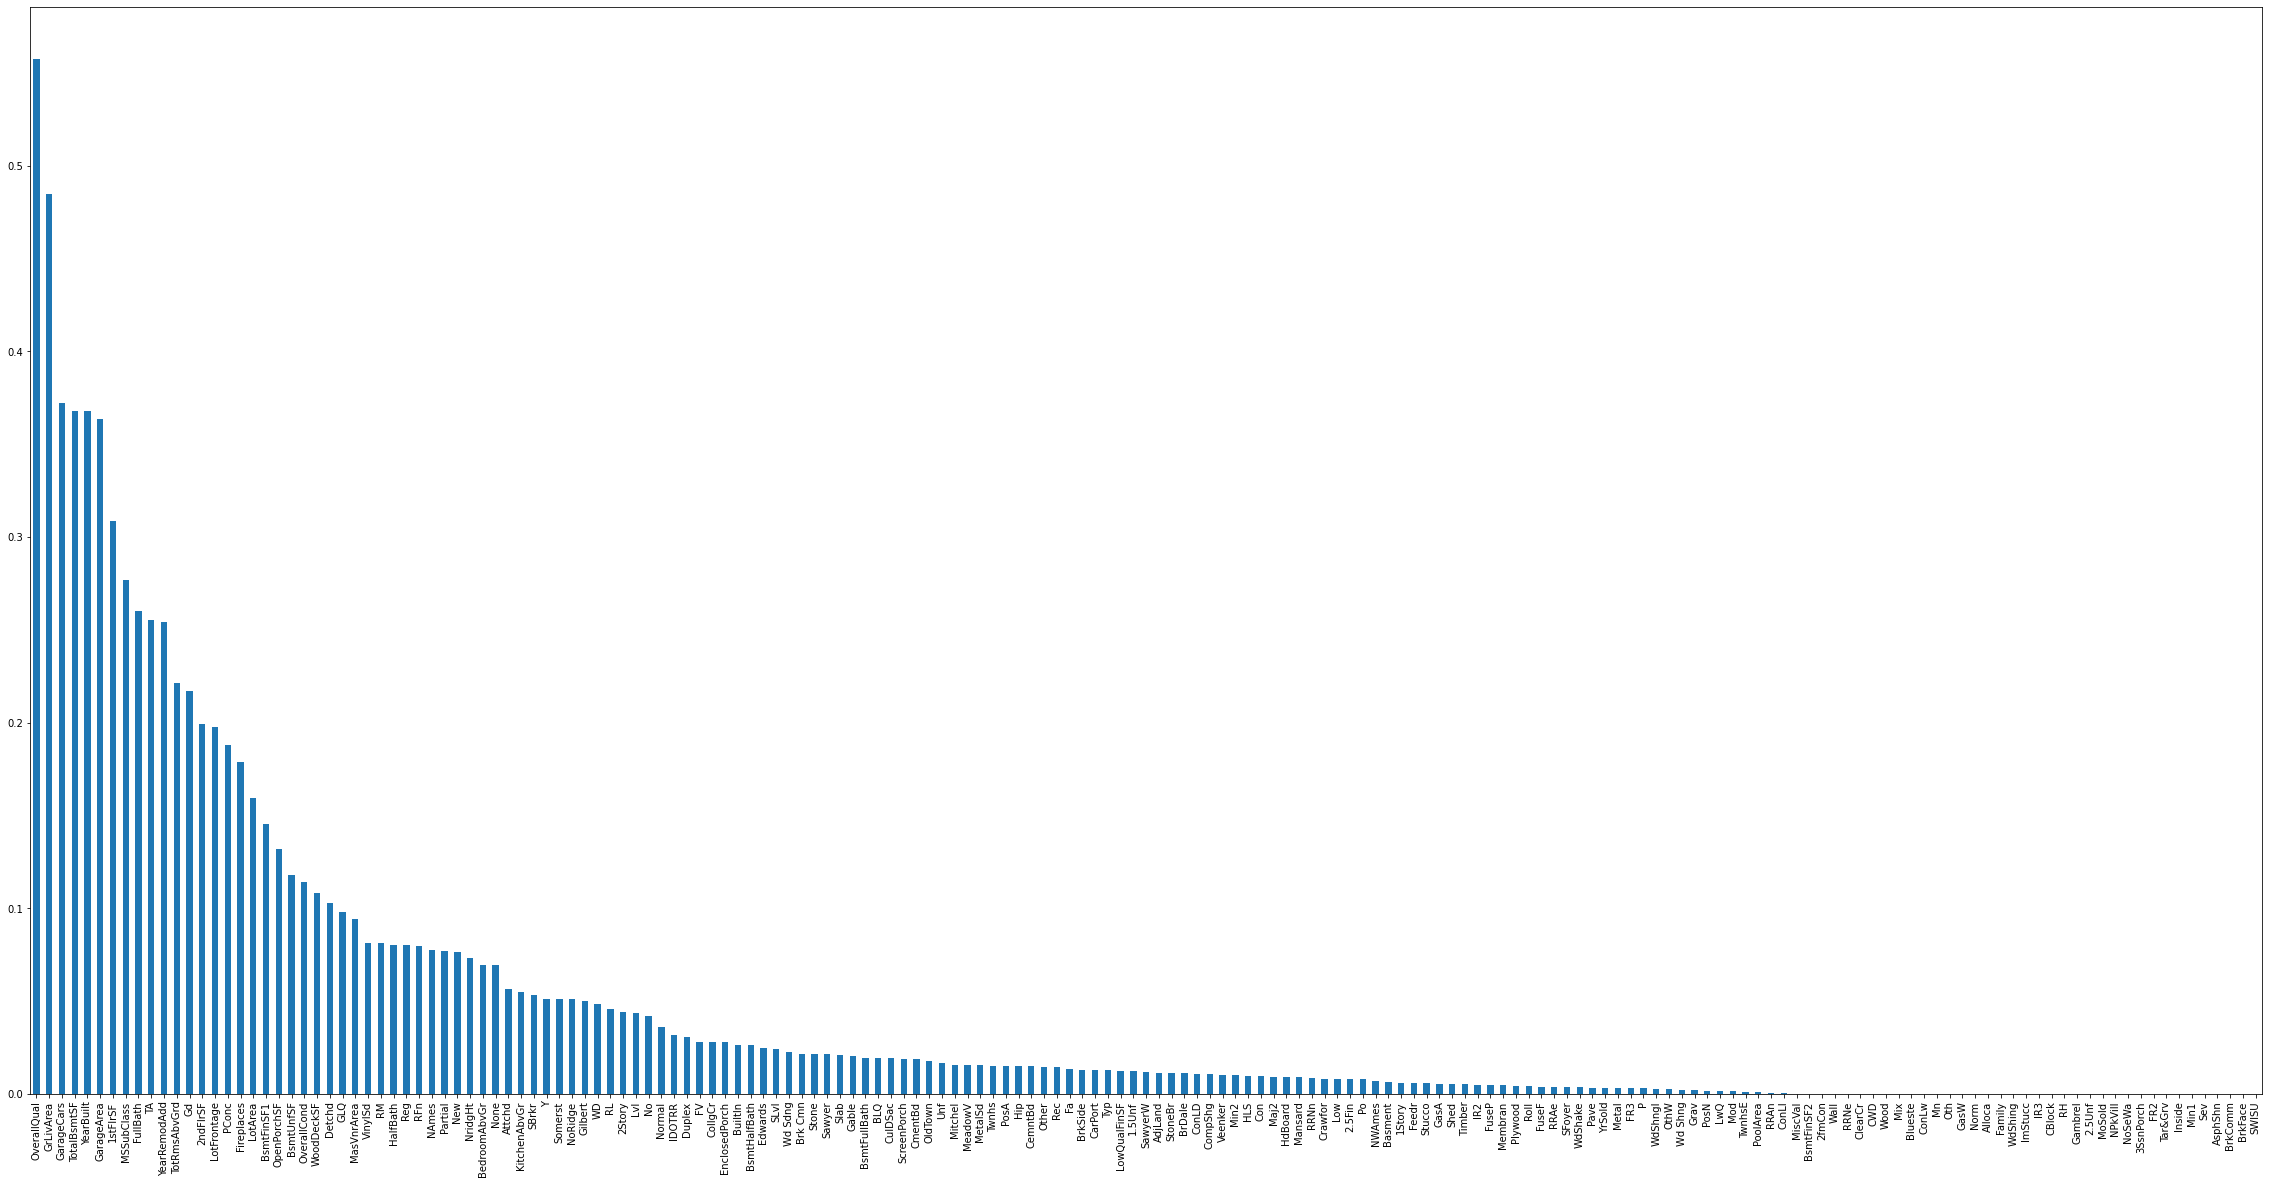

In [26]:
mi.index = X_train.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(40, 20))

In [30]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from mlxtend.feature_selection import SequentialFeatureSelector

feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           k_features=175,
           forward=True,     #Forward selection , False for backward selection
           floating=True,    #Floating on or off    Bidirectional floating                      
           verbose=1,
           scoring='neg_mean_squared_error')

In [ ]:
feature_selector.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bhavesh/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bhavesh/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bhavesh/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


# Feature selection using random forest classifer

In [74]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=42)

In [75]:
from xgboost import XGBRegressor

In [78]:
from sklearn.ensemble import RandomForestRegressor 
rf = XGBRegressor(n_estimators=50,random_state=1)
rf.fit(x_train, y_train) 


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [81]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#sqrt(mean_squared_error(y_test,rf.predict(x_test)))

# Applying hyperparameter optimization for XGboost


In [86]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [93]:
import xgboost
regressor=xgboost.XGBRegressor()

In [94]:
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }


In [103]:
# Set up the random search with 4-fold cross validation
random_cv = GridSearchCV(estimator=regressor,
            param_grid=hyperparameter_grid,
            cv=5,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            )


In [104]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   53.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  6.5min


KeyboardInterrupt: 

# Applying different algorithms now


In [31]:
import xgboost
regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=900,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
regressor.fit(X_train,y_train)

XGBoostError: [14:53:00] /workspace/src/objective/regression_obj.cu:60: Check failed: preds.Size() == info.labels_.Size() (1460 vs. 1168) : labels are not correctly providedpreds.size=1460, label.size=1168
Stack trace:
  [bt] (0) /home/bhavesh/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x54) [0x7f397ad50614]
  [bt] (1) /home/bhavesh/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LinearSquareLoss>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x187) [0x7f397affb797]
  [bt] (2) /home/bhavesh/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x376) [0x7f397ae3c9a6]
  [bt] (3) /home/bhavesh/.local/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x29) [0x7f397ad3f639]
  [bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f39df37edae]
  [bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7f39df37e71f]
  [bt] (6) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2b4) [0x7f39df5925c4]
  [bt] (7) /usr/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x11c33) [0x7f39df592c33]
  [bt] (8) /usr/bin/python3(_PyObject_FastCallKeywords+0x19c) [0x5a9cbc]



In [403]:
Output_Sales=regressor.predict(df_Test)

In [413]:
Training_values=regressor.predict(X_train)
Training_values=pd.DataFrame(Training_values)
Training_values

0
0     204240.031250
1     175631.531250
2     210394.640625
3     155374.718750
4     277177.250000
...             ...
1455  171948.468750
1456  197877.875000
1457  269730.375000
1458  141086.328125
1459  141663.484375

[1460 rows x 1 columns]

In [404]:
Output_Sales.size

1459

In [405]:
pred=pd.DataFrame(Output_Sales)

In [406]:
sub=pd.read_csv("sample_submission.csv")
sub.shape

(1459, 2)

In [407]:
dataset=pd.concat([sub['Id'],pred],axis=1)
dataset.columns=['Id','SalePrice']
dataset.to_csv('Mynewsubmission.csv',index=False)

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt




In [419]:
root_mean_squared_error(Training_values,y_train)

<tf.Tensor 'Sqrt_2:0' shape=() dtype=float64>